In [1]:
import torch
import matplotlib.pyplot as plt
from data.custom_dataset import uci_to_normalised_ttsplit
from models import MeanFieldBNN
from training import train
import pandas as pd

torch.set_default_dtype(torch.float64)

%load_ext autoreload
%autoreload 2

In [24]:
architecture = [6, 50, 50, 1]
scale_prior=False
likelihood_std=0.1
lr=1e-2
final_lr=5e-3
epochs = 10_000
heavy_fixed_nonzero = 1.0
light_fixed_nonzero = 4.0
train_proportion = 0.8

In [25]:
torch.manual_seed(0)

In [26]:
file_path = "data/yacht_hydrodynamics.data"

data_frame = pd.read_csv(file_path, header=None, delim_whitespace=True)

X_uci = data_frame.iloc[:, :-1]
y_uci = data_frame.iloc[:, -1]
X_train, y_train, X_test, y_test = uci_to_normalised_ttsplit(X_uci, y_uci, train_proportion=train_proportion)

/tmp/ipykernel_806/1087129732.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_frame = pd.read_csv(file_path, header=None, delim_whitespace=True)


FC neurons in layer 1: 6
FC neurons in layer 2: 20
FC neurons in layer 3: 20
FC neurons in layer 4: 1


  0%|          | 11/10000 [00:00<01:35, 105.01it/s, log posterior=tensor(-11773.8702), log likelihood=tensor(-11234.8369), log prior=tensor(-539.0334), test rmse=tensor(0.9563), test mlpp=tensor(-44.3402)]

100%|██████████| 10000/10000 [00:56<00:00, 177.90it/s, log posterior=tensor(-245.1459), log likelihood=tensor(332.6906), log prior=tensor(-577.8365), test rmse=tensor(0.0269), test mlpp=tensor(1.3476)]    


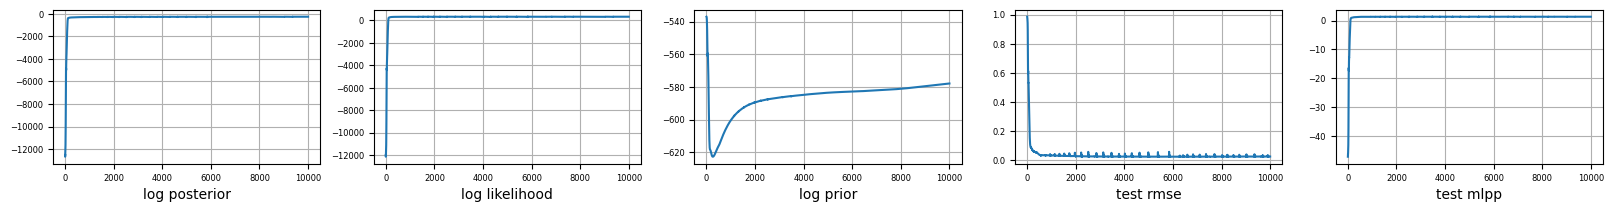

In [27]:
map_mlp = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
)
map_tracker = train(
    map_mlp,
    X_train,
    y_train,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    x_test=X_test,
    y_test=y_test,
)


fig, ax = plt.subplots(1, len(map_tracker.items()), figsize=(4*len(map_tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(map_tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
plt.show()

FC neurons in layer 1: 6
FC neurons in layer 2: 0
FC neurons in layer 3: 1
FC neurons in layer 4: 1


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:46<00:00, 93.97it/s, elbo=tensor(-32.0747), exp ll=tensor(270.5008), kl=tensor(302.5755), test rmse=tensor(0.0953), test mlpp=tensor(1.0791)]      


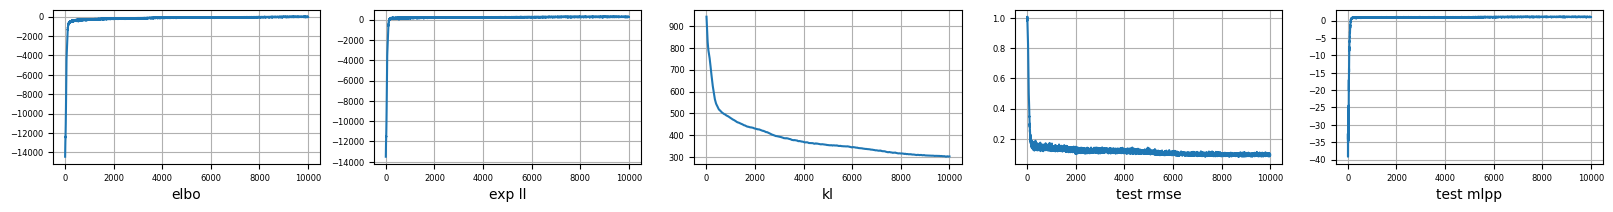

In [28]:
HAFN = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=False,
    c=heavy_fixed_nonzero,
    # train_c=True,
)

tracker = train(
    HAFN,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 6
FC neurons in layer 2: 0
FC neurons in layer 3: 1
FC neurons in layer 4: 1


  0%|          | 0/10000 [00:00<?, ?it/s, elbo=tensor(-13306.1728), exp ll=tensor(-11918.2870), kl=tensor(1387.8857), test rmse=tensor(0.9706), test mlpp=tensor(-30.0619), c=tensor(3.9700)]

100%|██████████| 10000/10000 [01:49<00:00, 90.98it/s, elbo=tensor(31.7361), exp ll=tensor(271.1913), kl=tensor(239.4552), test rmse=tensor(0.0781), test mlpp=tensor(1.1576), c=tensor(8.1001)]      


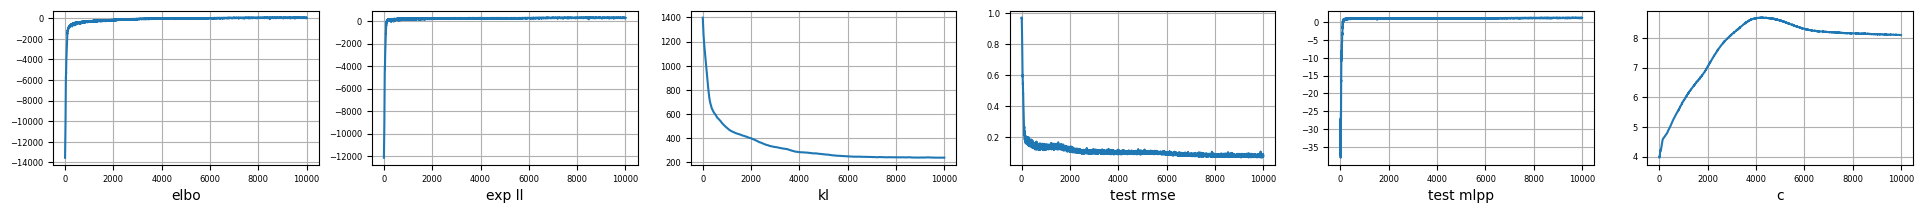

In [29]:
LAFN = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=True,
    c=light_fixed_nonzero,
    train_c=True,
)

tracker = train(
    LAFN,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 6
FC neurons in layer 2: 0
FC neurons in layer 3: 1
FC neurons in layer 4: 1


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:33<00:00, 106.57it/s, elbo=tensor(18.9957), exp ll=tensor(278.1164), kl=tensor(259.1207), test rmse=tensor(0.0939), test mlpp=tensor(1.1100)]      


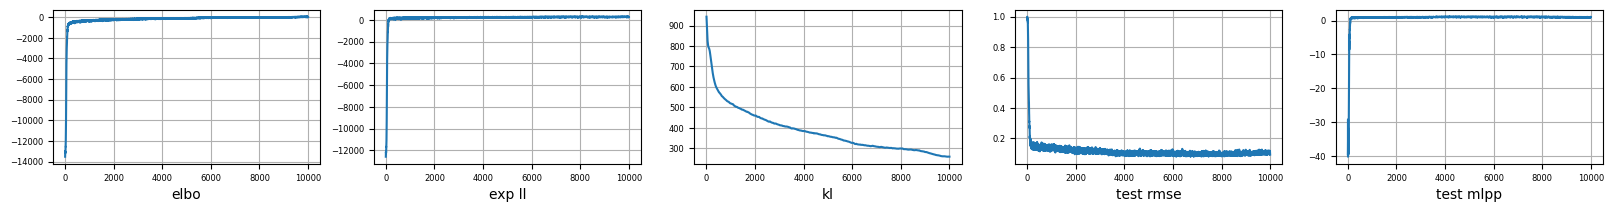

In [30]:
HApruned = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=False,
    c=0.0,
)

tracker = train(
    HApruned,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 6
FC neurons in layer 2: 0
FC neurons in layer 3: 1
FC neurons in layer 4: 1


  0%|          | 0/10000 [00:00<?, ?it/s, elbo=tensor(-13621.3356), exp ll=tensor(-12235.9946), kl=tensor(1385.3410), test rmse=tensor(0.9867), test mlpp=tensor(-35.6455)]

100%|██████████| 10000/10000 [01:32<00:00, 107.74it/s, elbo=tensor(-49.1010), exp ll=tensor(283.2448), kl=tensor(332.3458), test rmse=tensor(0.0893), test mlpp=tensor(1.1295)]     


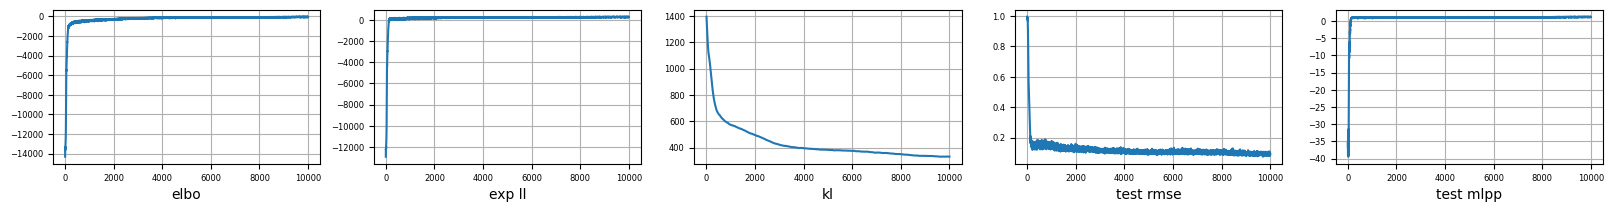

In [31]:
LApruned = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=True,
    c=0.0,
)

tracker = train(
    LApruned,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 6
FC neurons in layer 2: 0
FC neurons in layer 3: 1
FC neurons in layer 4: 1


  0%|          | 0/10000 [00:00<?, ?it/s, elbo=tensor(-13104.0187), exp ll=tensor(-12173.2481), kl=tensor(930.7706), test rmse=tensor(0.9894), test mlpp=tensor(-33.2961)]

100%|██████████| 10000/10000 [01:43<00:00, 97.04it/s, elbo=tensor(55.0889), exp ll=tensor(279.9124), kl=tensor(224.8235), test rmse=tensor(0.1049), test mlpp=tensor(1.0026)]       


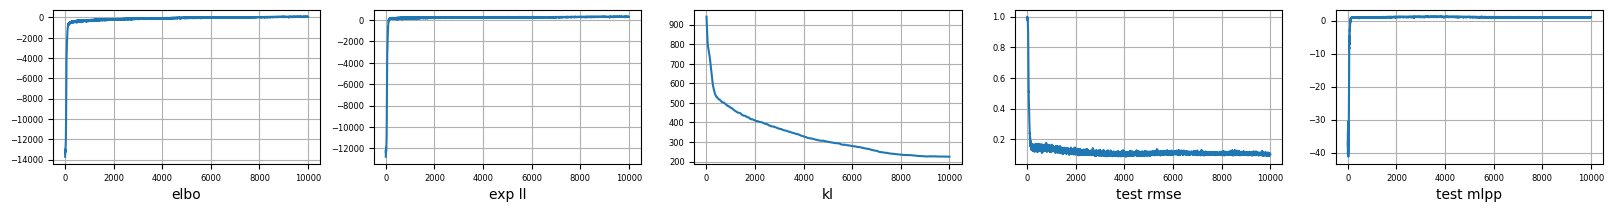

In [32]:
HAMAP = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=False,
    map_weights=[layer.w.detach() for layer in map_mlp.layers],
)

tracker = train(
    HAMAP,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 6
FC neurons in layer 2: 0
FC neurons in layer 3: 1
FC neurons in layer 4: 1


  0%|          | 0/10000 [00:00<?, ?it/s, elbo=tensor(-14093.8409), exp ll=tensor(-13158.8776), kl=tensor(934.9633), test rmse=tensor(1.0059), test mlpp=tensor(-36.3404)]

100%|██████████| 10000/10000 [01:44<00:00, 95.76it/s, elbo=tensor(6.7565), exp ll=tensor(271.0858), kl=tensor(264.3294), test rmse=tensor(0.0927), test mlpp=tensor(1.1270)]       


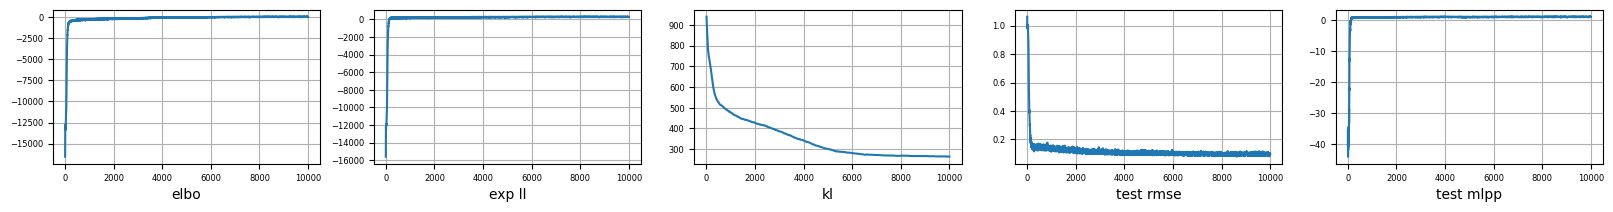

In [33]:
LAMAP = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=True,
    minimal_mask=False,
    map_weights=[layer.w.detach() for layer in map_mlp.layers],
)

tracker = train(
    LAMAP,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

FC neurons in layer 1: 6
FC neurons in layer 2: 20
FC neurons in layer 3: 20
FC neurons in layer 4: 1


  0%|          | 0/10000 [00:00<?, ?it/s, elbo=tensor(-13753.6618), exp ll=tensor(-12298.3168), kl=tensor(1455.3451), test rmse=tensor(0.9950), test mlpp=tensor(-29.2911)]

100%|██████████| 10000/10000 [01:29<00:00, 111.12it/s, elbo=tensor(-75.0235), exp ll=tensor(253.0121), kl=tensor(328.0356), test rmse=tensor(0.0863), test mlpp=tensor(1.1008)]      


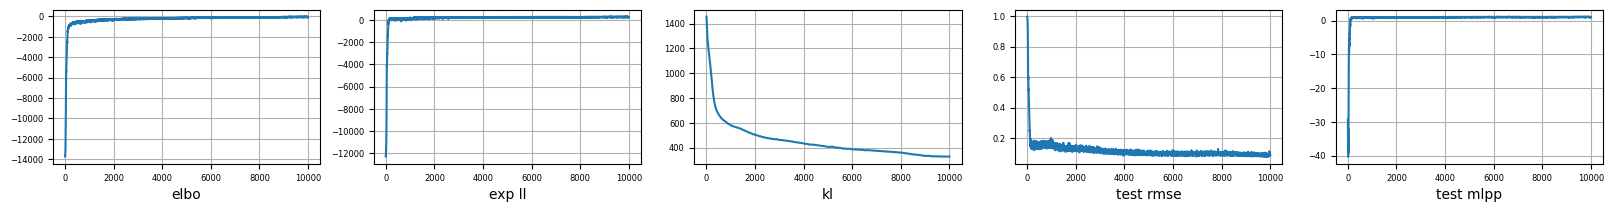

In [34]:
vanilla = MeanFieldBNN(
    architecture,
    scale_prior=scale_prior,
    likelihood_std=likelihood_std,
    asymmetric_weights=False,
)

tracker = train(
    vanilla,
    X_train,
    y_train,
    variational=True,
    epochs=epochs,
    learning_rate=lr,
    final_learning_rate=final_lr,
    num_samples=16,
    x_test=X_test,
    y_test=y_test,
)

fig, ax = plt.subplots(1, len(tracker.items()), figsize=(4*len(tracker.items()), 2), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

In [38]:
num_samps = 1000
results = []
models = [
    HAFN,
    LAFN,
    HApruned,
    LApruned,
    HAMAP,
    LAMAP,
    vanilla,
]
for model in models:
    results.append(model.evaluate(X_test, y_test, variational=True, num_samples=num_samps))

titles = [
    "HAFN",
    "LAFN",
    "HApruned",
    "LApruned",
    "HAMAP",
    "LAMAP",
    "vanilla"
]

for i, result in enumerate(results):
    print(titles[i] + ":      " + "rmse=", result[0], "  mlpp=", result[1])

HAFN:      rmse= tensor(0.0931)   mlpp= tensor(1.0988)
LAFN:      rmse= tensor(0.0808)   mlpp= tensor(1.1436)
HApruned:      rmse= tensor(0.0998)   mlpp= tensor(1.0853)
LApruned:      rmse= tensor(0.0922)   mlpp= tensor(1.1218)
HAMAP:      rmse= tensor(0.1021)   mlpp= tensor(1.0250)
LAMAP:      rmse= tensor(0.0961)   mlpp= tensor(1.1113)
vanilla:      rmse= tensor(0.0884)   mlpp= tensor(1.1201)
